In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [ ]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

In [4]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [7]:
num_qubit = backend.configuration().n_qubits
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
dt = backend.configuration().dt
basis_gates = backend.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

# Helper Fcuntions

In [8]:
colors = ['grey', 'green', 'crimson', 'cornflowerblue']

In [10]:
delay_shots = 1024

delay = Parameter('delay')
def gen_circ_delay(circ_type):
    qubit_list = list(range(num_qubit))
    
    circ = QuantumCircuit(num_qubit)
    if circ_type == 0:
        pass
    elif circ_type == 1:
        circ.x(qubit_list)
    elif circ_type == 2:
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
    elif circ_type == 3:
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        x23_gate = Gate("x23_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
            circ.append(x23_gate, [qubit])
            circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
    
    circ.barrier()

    circ.delay(delay, qubit_list)
    
    circ.measure_all()
    
    return circ

# Experiment for T1

In [11]:
t1_shots = 1024

## delay_step = 50000

delay_max = 2500000

In [12]:
# T1 experiment parameters
delay_step = 50000
delay_max = 2500000
delay_list = [get_closest_multiple_of(d, acquire_alignment) for d in range(0, delay_max + delay_step, delay_step)]

exp_t1_circs = [[gen_circ_delay(state).assign_parameters({delay: d}, inplace=False) for d in delay_list] for state in [1, 2, 3]]

In [21]:
job_list = []
job_id_list = []
for exp_t1_circ in exp_t1_circs:
    job = backend.run(exp_t1_circ,
                      rep_delay = 500e-6,
                      shots=t1_shots)
    job_list.append(job)
    job_id_list.append(job.job_id())
job_id_list

['6338563d604089052b8e14c7',
 '63385640a146b5056a1f7183',
 '633856441ff56904178b75a4']

In [91]:
job_id_list = ['6338563d604089052b8e14c7',
            '63385640a146b5056a1f7183',
            '633856441ff56904178b75a4']
job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
save_job(job_list, "data/t1_job.pickle")

In [ ]:
job_list = load_job("data/t1_job.pickle")

In [39]:
data = np.array([[[single_qubit_count([job.result().get_counts(i)], qubit) for qubit in range(num_qubit)] for i in range(len(exp_t1_circs[0]))] for job in job_list])/t1_shots

In [15]:
data.shape

(3, 51, 7, 1, 2)

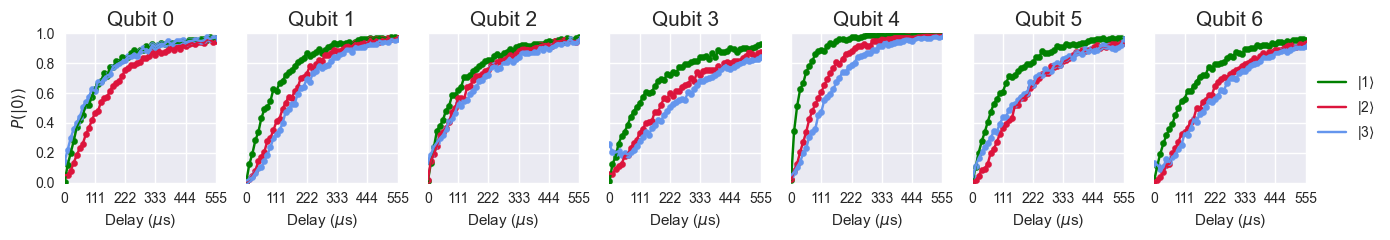

In [29]:
mpl.style.use('seaborn')

dt = backend.configuration().dt

fig, axes = plt.subplots(1, num_qubit, figsize = (14, 2.5), dpi = 100, sharey=True, sharex = True)

# fig.supxlabel("Delay (us)")

axes[0].set_ylabel(r"$P(|0\rangle)$")
for qubit in range(num_qubit):
    for state in range(3):
        if state == 0:
            axes[qubit].set_title(f"Qubit {qubit}", fontsize = 15)
        axes[qubit].plot(delay_list, data[state, :, qubit, 0, 0], c=colors[state+1], label = f"|{state + 1}"r"$\rangle$")
        axes[qubit].scatter(delay_list, data[state, :, qubit, 0, 0], c=colors[state+1], s = 20)
        plt.xlim([0, 2.5e6])
        plt.xticks(np.arange(0, 2500001, 500000), (np.arange(0, 2500001, 500000)*dt*1e6).astype(int))
        plt.ylim([0, 1])
        axes[qubit].set_xlabel("Delay ($\mu$s)")
        # axes[qubit].legend()
        if qubit == num_qubit - 1:
            axes[qubit].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.tight_layout()
# plt.savefig("./figs/p1_delay.pdf")

In [62]:
delay_data = np.log(data[:, :, :, 0, 1])
k_list = [[-1/np.polyfit(np.array(delay_list)*dt, delay_data[state, :, qubit], 1)[0]*1e6 for qubit in range(7)] for state in range(3)]
k_list

[[166.63499294819968,
  151.42230171123373,
  171.7162822991169,
  231.773272337857,
  114.91425255424319,
  161.0816329775678,
  175.04942075467054],
 [174.74879380291296,
  149.32818324804256,
  178.06610352508406,
  268.7877198568399,
  112.62523537158515,
  185.92151485265498,
  197.31285137036963],
 [168.73688501444454,
  161.24527049918993,
  189.69108167549533,
  308.2277112455062,
  131.88773181780834,
  203.32521804731385,
  215.32705459098216]]

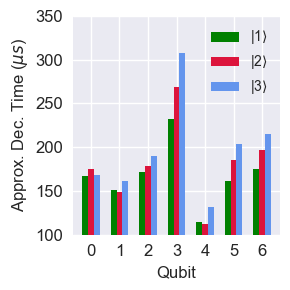

In [94]:
num_xtick = 7
num_bar = 3
barWidth = 0.2

mpl.style.use('seaborn')

plt.figure(figsize = (3, 3), dpi = 100)

br = [(np.arange(num_xtick) + barWidth * (i - (num_bar-1) / 2)) for i in range(num_bar)]
for state in range(3):
    plt.bar(br[state], k_list[state], width = barWidth, label = f"|{state+1}" r"$\rangle$", color=colors[state+1])

plt.xticks(range(7), range(7), fontsize = 12)
plt.xlabel("Qubit", fontsize = 12)
plt.ylabel(r"Approx. Dec. Time ($\mu s$)", fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim((100, 350))
plt.legend()
plt.tight_layout()

# plt.savefig("./figs/decoherence_time.pdf")

In [14]:
job_list = []
job_id_list = []
for exp_t1_circ in exp_t1_circs:
    job = backend.run(exp_t1_circ, 
                      meas_level=1, 
                      meas_return='single',
                      rep_delay = 500e-6,
                      shots=t1_shots)
    job_list.append(job)
    job_id_list.append(job.job_id())
job_id_list

['63385355dee3d63991b9124a',
 '63385358604089048f8e14bd',
 '6338535a1ff56910e78b759a']

In [82]:
job_id_list = ['63385355dee3d63991b9124a',
            '63385358604089048f8e14bd',
            '6338535a1ff56910e78b759a']
job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
save_job(job_list, "data/iq_job.pickle")

In [ ]:
job_list = load_job("data/iq_job.pickle")

In [83]:
data = np.array(get_job_data(job_list, average=False, scale_factor=1e-7))

In [38]:
data.shape

(3, 7, 51, 1024)

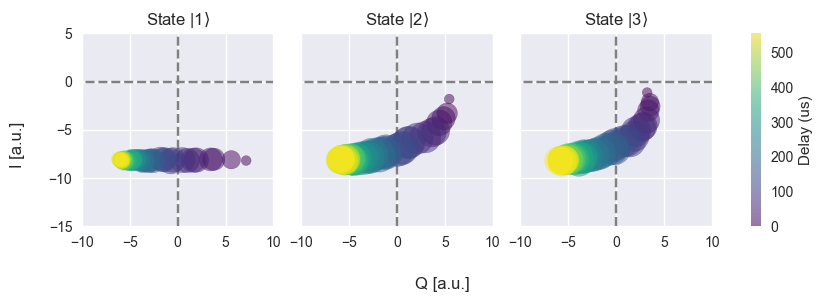

In [23]:
mpl.style.use('seaborn')

qubit = 2


fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=100, sharey=True, sharex = True)

fig.supxlabel('Q [a.u.]')
fig.supylabel('I [a.u.]')

for state in range(3):
    axes[state].set_title(f"State |{state+1}" r"$\rangle$")

    c = np.array(range(data.shape[2])) * dt * 1e6 * delay_step
    
    plot_data = data[state, qubit, :, :].mean(axis = -1)
    
    axes[state].plot([0, 0], [-15, 15], c = "grey", linestyle = "dashed", zorder=1)
    axes[state].plot([-15, 15], [0, 0], c = "grey", linestyle = "dashed", zorder=1)

    plot = axes[state].scatter(np.real(plot_data), np.imag(plot_data), 
                s=50 + 100 * (np.std(data[state, qubit, :, :], axis = -1) - np.min(np.std(data[state, qubit, :, :], axis = -1))), 
                alpha=0.5, c=c, cmap='viridis', zorder=2)
    
    axes[state].set_xlim(-10, 10)
    axes[state].set_ylim(-15, 5)
    
fig.tight_layout()
fig.colorbar(plot, ax = axes, label = "Delay (us)")

# plt.savefig("./figs/amp_evolution.pdf")

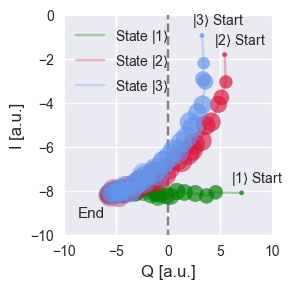

In [88]:
mpl.style.use('seaborn')

qubit = 0

plt.figure(figsize=(3, 3), dpi=100)

plt.xlabel('Q [a.u.]', fontsize = 12)
plt.ylabel('I [a.u.]', fontsize = 12)

plt.plot([0, 0], [-15, 15], c = "grey", linestyle = "dashed", zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 0)

for state in range(3):
    alphas = 0.7 - np.array(delay_list)/delay_list[-1] * 0.6
    
    plot_data = data[state, qubit, :, :].mean(axis = -1)

    plt.text(np.real(plot_data)[0]-1, np.imag(plot_data)[0]+0.5, f"|{state+1}" r"$\rangle$ ""Start")
    plt.plot(np.real(plot_data), np.imag(plot_data),
                alpha=0.3, zorder=1, c = colors[state + 1], label = f"State |{state+1}" r"$\rangle$")
    plt.scatter(np.real(plot_data), np.imag(plot_data), 
                s=10 + 50 * (np.std(data[state, qubit, :, :], axis = -1) - np.min(np.std(data[state, qubit, :, :], axis = -1))), 
                alpha=alphas, c = colors[state + 1], zorder=2)

plt.text(np.real(plot_data)[-1] - 3, np.imag(plot_data)[-1] - 1.0, "End", fontsize = 11)
plt.legend(loc = 'upper left')
plt.tight_layout()
# plt.colorbar(label = "Delay (us)")
# plt.colorbar(plot, label = "Delay (us)")

# plt.savefig("./figs/amp_evolution.pdf")